In [1]:
# pip install spacy
# python -m spacy download en_core_web_sm

In [1]:
import os
import matplotlib.pyplot as plt
import spacy
from collections import Counter, OrderedDict
import re

nlp = spacy.load("en_core_web_sm")

In [2]:
# functions to read the log file, needs spacy

def find_verb(sent):
    """ Find verb/root, check spacy model for language. """
    
    to_remove = ['[SEP]', '[CLS]', '<pad>']
    temp = [x for x in sent.split(' ') if not x in to_remove]
    
    doc = nlp(' '.join(temp))
    head = False
    head_idx = False
    lemma = False
    for num, token in enumerate(doc):
        if token.pos_ == 'VERB' and token.dep_ == 'ROOT':
            head = token.text
            head_idx = num
            lemma = token.lemma_
    if not head:
        for token in doc:
            if token.pos_ == 'VERB':
                head = token.text
                head_idx = num
                lemma = token.lemma_
    if not head:
        for token in doc:
            if token.dep_ == 'ROOT':
                head = token.text
                head_idx = num
                lemma = token.lemma_

    return head, head_idx, lemma

def process_sentence(line):
    
    l = line.strip().split('\t')
    
    if line.startswith('right'):
        label = l[0][-1]
    else: 
        label = abs(int(l[0][-1]) -1) # flip the wrong label to right
        
    probabilities = {0: float(re.search('\[(.*),', l[1]).group(1)), 
                     1: float(re.search(',\s(.*)\]', l[1]).group(1))}
    
    temp = re.sub('\d{1,3}\sout\sof\s\d{1,3}', '', l[-1])
    sentence = temp.strip().replace(' ##', '').replace(' ###', '')
    head, head_idx, lemma = find_verb(sentence)
    
    output = {'sent': sentence, 'label': label, 'probs': probabilities,
           'head': head, 'head_idx': head_idx, 'head_lemma': lemma}
    
    return output

In [3]:
# see all the X models for Y trained on Z

data_source = 'friedrich_captions_data'
marker = 'telicity'
model = 'bert-base-uncased'
use_segment_ids = 'no'

val_sents = {'wrong': [], 'right': []}     # validation set
test_sents = {'wrong': [], 'right': []}    # test set from the dataset
unseen_sents = {'wrong': [], 'right': []}  # 40 test sentences 
min_sents = {'wrong': [], 'right': []}     # minimal pairs

with open(data_source + '/' + marker + '/' + model + '_' + use_segment_ids + '.log', 'r') as f:

    for line in f:
        # val sents
        if line.startswith('wrong_val:'):
            val_sents['wrong'].append(process_sentence(line))
        elif line.startswith('right_val:'):
            val_sents['right'].append(process_sentence(line))
        #test sents
        if line.startswith('wrong_seen:'):
            test_sents['wrong'].append(process_sentence(line))
        elif line.startswith('right_seen:'):
            test_sents['right'].append(process_sentence(line))
        # 40 test sents
        if line.startswith('wrong_unseen:'):
            unseen_sents['wrong'].append(process_sentence(line))
        elif line.startswith('right_unseen:'):
            unseen_sents['right'].append(process_sentence(line))
        # min pairs
        if line.startswith('wrong_min:'):
            min_sents['wrong'].append(process_sentence(line))
        elif line.startswith('right_min:'):
            min_sents['right'].append(process_sentence(line))


In [4]:
# Show X sentences for which the models were confident > 0.8 but wrong

wrong_telic = []
wrong_atelic = []

for sent in test_sents['wrong']:
    if sent['label'] == 0 and sent['probs'][0] < 0.2:
        wrong_telic.append(sent['sent'])
    
    elif sent['label'] == 1 and sent['probs'][1] < 0.2:
        wrong_atelic.append(sent['sent'])

print('"Confident" wrong predictions (show 10):')

print('\nTelic sentences that were predicted as atelic:')
for s in wrong_telic[:10]:
    print('  *  ' + s)

print('\nAtelic sentences that were predicted as telic:')
for s in wrong_atelic[:10]: 
    print('  *  ' + s)

"Confident" wrong predictions (show 10):

Telic sentences that were predicted as atelic:
  *  if this cats for real , i bet my friend can tell you everything you need to know . ” youre a wonder , dvorov .
  *  the next time the crowd split , i saw him .
  *  i hope i have n ' t portrayed it as one big swamp , fraught with danger .
  *  the feeling that she could outrun anything .
  *  instead i bring you news . . . ” " you ' re so unbelievably alienated from yourself , " becky said .
  *  to showcase just one brave stranger .
  *  it felt good to have helped make that happen , to have been part of stimulating something inside their brains or hearts that caused them to care so passionately , and - oh wonder of wonders !
  *  they stick to small paths and open fields , sleeping in ditches , pilfering from farmsteads clinging to the edge of hills : eggs , chickens , even dried maize .
  *  young girls braided their hair in the shade , while their mothers worked over the fires .
  *  in an

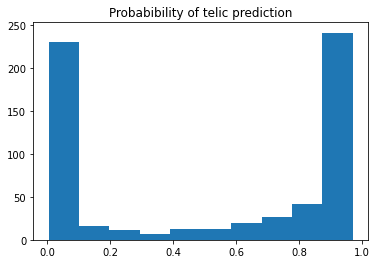

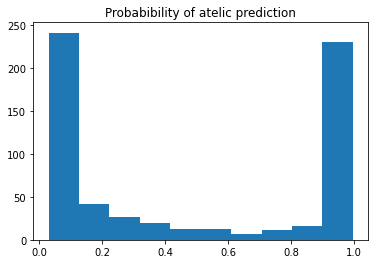

In [5]:
# Print histograms of probabilities, *regardless* of label or prediction

all_telic_probs = []
all_atelic_probs = []

for sent in test_sents['wrong']  + test_sents['right']:
    all_telic_probs.append(sent['probs'][0])
    all_atelic_probs.append(sent['probs'][1])

plt.title('Probabibility of telic prediction')
plt.hist(all_telic_probs)
plt.show()
plt.cla()

plt.title('Probabibility of atelic prediction')
plt.hist(all_atelic_probs)
plt.show()
# plt.cla()

Counts of verb "feel" in test + val:  14

  *   0    it felt good to have helped make that happen , to have been part of stimulating something inside their brains or hearts that caused them to care so passionately , and - oh wonder of wonders !
  *   1    zaphod felt he was teetering on the edge of madness and wondered if he shouldn t just jump over and have done with it .
  *   0    the stake went down , there was a blur , and then my hands were empty and i felt pain under my jaw .
  *   0    he was feeling more and more uncomfortable and wanted to end this visit to hedeby , but he relented .
  *   0    she was forbidden to help , and jackson , of course , had never laundered a thing in his life ; when he ' d emerged into the giddy heat of the garage , he felt behind him and round he could comfortably insert his first two fingers into a rent in the material .
  *   0    she felt only how sally was being mauled already , maltreated ; to get that good at rebuffing a man ' s attention sh

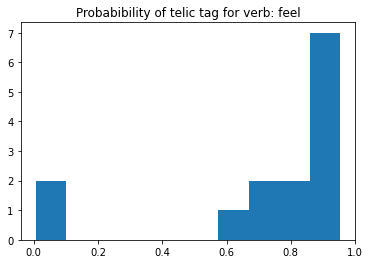

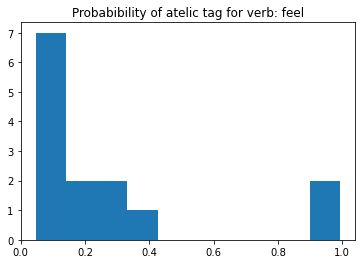

In [6]:
# Plot distribution per verb, e.g. 'stand'

per_verb = {}
exclude_verbs = ['re', 's', 't', 'be', 'have', 'do', 'dr', 'ca', 'in', '"', ',', 'a']

for sent in test_sents['wrong'] + test_sents['right'] + val_sents['wrong'] + val_sents['right']:
    if not sent['head_lemma'] in exclude_verbs: 
        if sent['head_lemma'] not in per_verb: 
            per_verb[sent['head_lemma']] = []
        per_verb[sent['head_lemma']].append(sent)
        
# See list of verbs:
# print(per_verb.keys())

# some telic verbs: look, open, arrest, bling, break, cut, drop, give, shoot
# some atelic verbs: see, admire, allow, begin, realize, believe, feel, prepare, visit, sit, stand

# plot for ONLY one verb
target_verb = 'feel'
print('Counts of verb "' + target_verb + '" in test + val: ', len(per_verb[target_verb]))
print()

all_telic_probs = []
all_atelic_probs = []
for sent in per_verb[target_verb]:
    print('  *  ', sent['label'], '  ', sent['sent'])
    all_telic_probs.append(sent['probs'][0])
    all_atelic_probs.append(sent['probs'][1])
    
plt.title('Probabibility of telic tag for verb: ' + target_verb)
plt.hist(all_telic_probs)
plt.show()
plt.cla()

plt.title('Probabibility of atelic tag for verb: ' + target_verb)
plt.hist(all_atelic_probs)
plt.show()

In [26]:
# Look at the performance of the qualitative sets
# NB: the label printed here is the *correct* annotation, not the prediction

print('\t==== Wrong Predictions ==== \nLabel\t Verb \t Sentence')
for sent in unseen_sents['wrong']:
    print(sent['label'], '\t', sent['head'], '\t', sent['sent'])
    
print('\n\t==== Right Predictions ==== \nLabel\t Verb \t Sentence')
for sent in unseen_sents['right']:
    print(sent['label'], '\t', sent['head'], '\t', sent['sent'])

	==== Wrong Predictions ==== 
Label	 Verb 	 Sentence
0 	 ate 	 i ate a fish for lunch .
0 	 built 	 john built a house in a year .
0 	 drank 	 the cat drank all the milk .
0 	 ran 	 yesterday i ran a mile in under 10 minutes .
0 	 lasted 	 the classes lasted one hour and took place twice a week over a four - week period .
0 	 opens 	 she opens the door and the dog jumps in her lap .
0 	 changed 	 the advancements in technology have changed the world .
0 	 made 	 louise made the biggest progress of everyone this year .
0 	 born 	 jean was born in 1993 in lyon .

	==== Right Predictions ==== 
Label	 Verb 	 Sentence
0 	 spilled 	 i spilled the milk .
0 	 checked 	 the inspector checked our tickets after the first stop .
0 	 hung 	 i hung the picture on the wall .
0 	 broke 	 the vase broke in a million pieces .
0 	 kicked 	 john kicked the door shut .
0 	 opened 	 i opened the juice bottle .
0 	 written 	 kim has written a song .
0 	 fell 	 you fell for my trap again .
0 	 destroyed 	 the

In [27]:
# Look at the performance of the minimum sets (only for telicity)
# NB: the label printed here is the *correct* annotation, not the prediction

print('\t==== Wrong Predictions ==== \nLabel\t Verb \t Sentence')
for sent in min_sents['wrong']:
    print(sent['label'], '\t', sent['head'], '\t', sent['sent'])
    
print('\n\t==== Right Predictions ==== \nLabel\t Verb \t Sentence')
for sent in min_sents['right']:
    print(sent['label'], '\t', sent['head'], '\t', sent['sent'])

	==== Wrong Predictions ==== 
Label	 Verb 	 Sentence
0 	 walked 	 the girl walked a kilometer yesterday .
1 	 receive 	 i will receive new stock on fridays .
0 	 eating 	 the boy is eating an apple .
1 	 made 	 the prime minister made that declaration for months .
0 	 painted 	 the workers painted the house in an hour .
1 	 stopped 	 i stopped reading the book at 5 pm .
0 	 freezing 	 the pond is freezing over .
0 	 draws 	 the artist draws a painting .
0 	 noticed 	 she noticed him .
1 	 looked 	 she looked at him .
0 	 ate 	 she ate that sandwich .

	==== Right Predictions ==== 
Label	 Verb 	 Sentence
1 	 walked 	 the girl walked yesterday .
0 	 receive 	 i will receive new stock on friday .
1 	 eating 	 the boy is eating apples .
0 	 drank 	 i drank the whole bottle .
1 	 drank 	 i drank juice .
0 	 read 	 i read the book in an hour .
1 	 read 	 i read the book for an hour .
0 	 made 	 the prime minister made that declaration yesterday .
1 	 painted 	 the workers painted the house f